In [1]:
import sqlite3
import pandas as pd
import numpy as np


def trim_start_end_nans(df):
    """
    Removes rows at the start and end of a DataFrame that have NaN values in any column.
    """
    # Initialize start_idx and end_idx based on the DataFrame's index type
    if isinstance(df.index, pd.DatetimeIndex):
        start_idx = df.index[0]  # Assume first index is earliest; adjust if necessary
        end_idx = df.index[-1]  # Assume last index is latest; adjust if necessary
    else:
        start_idx = 0
        end_idx = len(df) - 1

    for column in df.columns:
        # Find the first non-NaN index in the current column
        first_valid_index = df[column].first_valid_index()
        if first_valid_index is not None and df.index.get_loc(first_valid_index) > df.index.get_loc(start_idx):
            start_idx = first_valid_index

        # Find the last non-NaN index in the current column
        last_valid_index = df[column].last_valid_index()
        if last_valid_index is not None and df.index.get_loc(last_valid_index) < df.index.get_loc(end_idx):
            end_idx = last_valid_index

    # Trim the DataFrame
    return df.loc[start_idx:end_idx]

# Now, apply the updated function to the DataFrame

def process_data_for_plot(plot_number, start_date='2023-07-20', end_date='2023-09-03'):
    """
    Process data for a given plot number within a specified date range.

    Parameters:
    - plot_number: The plot number to filter the data by.
    - start_date: The start date of the period to filter the data.
    - end_date: The end date of the period to filter the data.

    Returns:
    - A processed DataFrame with the data for the specified plot and date range.
    """
    # Connect to the database and load data
    conn = sqlite3.connect('processed_data.db')
    query = 'SELECT * from data_table'
    df = pd.read_sql_query(query, conn)
    conn.close()

    # Filter by plot_number
    df = df[df['plot_number'] == plot_number]

    # Filter by date range
    df = df[(df['TIMESTAMP'] >= start_date) & (df['TIMESTAMP'] <= end_date)]

    # Timestamp cyclical encoding
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['day_sin'] = np.sin(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['day_cos'] = np.cos(df['TIMESTAMP'].dt.dayofyear / 365 * 2 * np.pi)
    df['hour_sin'] = np.sin(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['hour_cos'] = np.cos(df['TIMESTAMP'].dt.hour / 24 * 2 * np.pi)
    df['dow_sin'] = np.sin(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)
    df['dow_cos'] = np.cos(df['TIMESTAMP'].dt.dayofweek / 7 * 2 * np.pi)

    # Define columns for processing
    time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']

    # Columns for correlation matrix
    corr_columns = [
        'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 
        'Dp_2m_Avg', 'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg', 
        'canopy_temp', 'VWC_06', 'VWC_18', 'VWC_30', 
        'daily_et', 'CWSI', 'SWSI', 'precip_irrig'
    ]

    # Eliminate duplicate indices and set TIMESTAMP as index
    df = df.drop_duplicates().set_index('TIMESTAMP').sort_index()

    # Assuming trim_start_end_nans is a predefined function to handle NaN values
    df = trim_start_end_nans(df)

    # Interpolate missing values
    df = df[corr_columns + time_columns].interpolate(method='pchip')

    return df



In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2 
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def subtract_mean(df, target_columns, keep_original_cols=True):
    mean_values = {}
    for col in target_columns:
        mean_value = df[col].mean()
        # When keep_original_cols is True, subtract the mean from a new column
        if keep_original_cols:
            new_col_name = f"{col}_mean_subtracted"
            df[new_col_name] = df[col] - mean_value
        else:
            df[col] -= mean_value
        mean_values[col] = mean_value
    return df, mean_values



def create_derivative_columns(df, target_columns, keep_original_cols=True):
    """Calculates difference-based derivatives of specified columns.

    Args:
        df: Pandas DataFrame containing the data.
        target_columns: List of columns for which derivatives are calculated.
        keep_original_cols: If True, creates new columns; otherwise overwrites.

    Returns:
        DataFrame with derivative columns, plus initial values if needed.
    """

    initial_values = {}  # Store initial values for reconstruction

    for col in target_columns:
        deriv_col_name = f"{col}_deriv"

        if keep_original_cols:
            df[deriv_col_name] = df[col].diff()  # Calculate differences
        else:
            initial_values[col] = df[col].iloc[0]  # Store initial value
            df[col] = df[col].diff()  

        # Plot the original and derived columns
        # plt.figure(figsize=(10, 6))
        # plt.plot(df[col], label=col)
        # plt.plot(df[deriv_col_name], label=deriv_col_name)
        # plt.xlabel('Time')
        # plt.ylabel('Value')
        # plt.title(f'{col} vs {deriv_col_name}')
        # plt.legend()
        # plt.show()
        

    return df, initial_values  # Return initial values as well

def scale_dataframe(df, scalers):
    """
    Scale all columns in a DataFrame using MinMaxScaler. If a scaler exists in the dictionary for a column, 
    use it; otherwise, create a new scaler, fit it, and add it to the dictionary.

    Args:
        df (pd.DataFrame): DataFrame containing the columns to be scaled.
        scalers (dict): Dictionary of pre-existing scalers.

    Returns:
        pd.DataFrame: The scaled DataFrame.
        dict: Updated dictionary of scalers.
    """
    for column in df.columns:
        if column in scalers:
            # Use the existing scaler for the column
            df[column] = scalers[column].transform(df[[column]])
        else:
            # Create a new scaler for the column, fit it, and update the dictionary
            scaler = MinMaxScaler(feature_range=(0, 1))
            df[column] = scaler.fit_transform(df[[column]])
            scalers[column] = scaler
    return df, scalers

def transform_and_scale_data(df, target_columns, scalers, keep_original_cols=True):
    """
    Transforms and scales the data in the DataFrame for neural network input, returning the
    transformed DataFrame, updated scalers, and transformation metadata.

    Args:
        df (pd.DataFrame): The input DataFrame.
        target_columns (list): List of target column names.
        scalers (dict): Dictionary containing MinMaxScalers for each column, can be empty.
        keep_original_cols (bool): If True, keeps original columns unchanged except for scaling;
                                   if False, applies transformations directly on the target columns.

    Returns:
        pd.DataFrame: The transformed and scaled DataFrame.
        dict: Updated dictionary containing MinMaxScalers for each column.
        dict: A dictionary containing transformation metadata for the target columns.
    """

    # Copy DataFrame to avoid modifying the original
    df_transformed = df.copy()

    # Apply transformations directly using helper functions
    df_transformed, initial_values = create_derivative_columns(df_transformed, target_columns, keep_original_cols)
    
    # Deleting or adjusting rows as necessary (e.g., due to NaN values from differentiation)
    df_transformed = df_transformed.iloc[1:]
    
    # Subtract mean from target columns
    df_transformed, mean_values = subtract_mean(df_transformed, target_columns, keep_original_cols)
    
    # Scale all columns in df_transformed
    df_transformed, scalers = scale_dataframe(df_transformed, scalers)
    
    # Metadata for reverse transformation
    transformation_metadata = {
        'means': mean_values,
        'scalers': scalers,
        'keep_original_cols': keep_original_cols,
        'initial_values': initial_values
    }

    return df_transformed, transformation_metadata


def reverse_transform_and_scale_data(df, transformation_metadata, target_columns):
    """
    Reverses the transformations and scaling applied to the DataFrame.

    Args:
        df (pd.DataFrame): The transformed and scaled DataFrame.
        transformation_metadata (dict): A dictionary containing transformation metadata.
        target_columns (list): List of target columns to be reverse transformed and scaled.

    Returns:
        pd.DataFrame: The DataFrame with reversed transformations and scaling.
    """

    # Extract metadata
    scalers = transformation_metadata['scalers']
    mean_values = transformation_metadata['means']
    initial_values = transformation_metadata['initial_values']
    keep_original_cols = transformation_metadata['keep_original_cols']

    # Print dimensions of df
    print(f"Shape of input DataFrame: {df.shape}")


    # Apply undifferencing with cumsum() and initial values if original columns were not kept
    if not keep_original_cols:
        for column in target_columns:
            # Reverse subtract mean from target columns if they were mean-adjusted
            if column in mean_values:
                df[column] = df[column] + mean_values[column]
                print(f"Reversed mean for {column}: ", df[column].head())

            # Apply cumsum() to reverse the differencing using initial values
            if column in initial_values:
                df[column] = df[column].cumsum() + initial_values[column]
                print(f"Undifferenced {column}: ", df[column].head())
                
    # Reverse scale the target columns
    for column in target_columns:
        if column in scalers:
            # Reshape data for inverse_transform
            scaled_data = df[[column]].values
            # Apply inverse_transform
            df[column] = scalers[column].inverse_transform(scaled_data)

    return df




# Sequence Creation Function
def create_sequences(input_data, target_data, input_window, forecast_horizon, stride=1):
    X, y = [], []
    for start in range(len(input_data) - input_window - forecast_horizon + stride):
        end = start + input_window
        X.append(input_data[start:end])
        y.append(target_data[end:end + forecast_horizon])
    return np.array(X), np.array(y)

# Model Definition Function for 4 Target Variables
def build_model(input_shape, num_targets):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True), 
        LSTM(64, return_sequences=False),  
        Dense(96 * num_targets), 
        Reshape((96, num_targets)) 
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def chronological_split(X, y, test_size=0.2):
    # Calculate the index to split the data
    total_samples = len(X)
    split_index = int(total_samples * (1 - test_size))
    
    # Split the data chronologically
    X_train = X[:split_index]
    X_val = X[split_index:]
    y_train = y[:split_index]
    y_val = y[split_index:]
    
    return X_train, X_val, y_train, y_val


# Define the training step
@tf.function
def train_step(model, optimizer, loss_function, x_batch, y_batch):
    with tf.GradientTape() as tape:
        predictions = model(x_batch, training=True)
        loss = loss_function(y_batch, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Define the validation step
@tf.function
def val_step(model, loss_function, x_batch, y_batch):
    predictions = model(x_batch, training=False)
    loss = loss_function(y_batch, predictions)
    return loss

def run_workflow(training_data_transformed, target_variables, input_window, forecast_horizon, stride, epochs, batch_size):
    X_train_all, X_val_all, y_train_all, y_val_all = [], [], [], []
    dataframe_identifiers = []

    # Data preparation
    for i, transformed_data in enumerate(training_data_transformed()):
        df = transformed_data[0]
        X, y = create_sequences(df.values, df[target_variables].values, input_window, forecast_horizon, stride)
        X_train, X_val, y_train, y_val = chronological_split(X, y)

        X_train_all.append(X_train)
        X_val_all.append(X_val)
        y_train_all.append(y_train)
        y_val_all.append(y_val)
        dataframe_identifiers.append(f"DataFrame_{i}")

    model = build_model((input_window, X_train_all[0].shape[2]), len(target_variables))
    optimizer = tf.keras.optimizers.Adam()
    loss_function = tf.keras.losses.MeanSquaredError()

    best_val_loss = np.inf
    checkpoint_path = "./LSTM_data"
    patience = 10  # Early stopping patience
    wait = 0  # Counter for epochs waited without improvement

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_val_loss = 0

        # Training
        for idx, (X_train, y_train) in enumerate(zip(X_train_all, y_train_all)):
            dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
            for x_batch, y_batch in dataset:
                train_step(model, optimizer, loss_function, x_batch, y_batch)

        # Validation
        for idx, (X_val, y_val) in enumerate(zip(X_val_all, y_val_all)):
            dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
            val_losses = []
            for x_batch, y_batch in dataset:
                val_loss = val_step(model, loss_function, x_batch, y_batch)
                val_losses.append(val_loss)
            avg_val_loss = tf.reduce_mean(val_losses)
            total_val_loss += avg_val_loss
            print(f"Validation loss for {dataframe_identifiers[idx]}: {avg_val_loss.numpy()}")

        average_val_loss = total_val_loss / len(X_val_all)
        print(f"Average validation loss for epoch {epoch+1}: {average_val_loss.numpy()}")

        # Early stopping and model saving logic
        if average_val_loss < best_val_loss:
            best_val_loss = average_val_loss
            model.save(checkpoint_path)
            print(f"Model saved at epoch {epoch+1} with validation loss: {average_val_loss.numpy()}")
            wait = 0  # Reset wait counter after improvement
        else:
            wait += 1
            if wait >= patience:
                print(f"Stopping early due to no improvement in validation loss for {patience} epochs.")
                break

    return checkpoint_path




# Example Usage
plot_numbers = [2014, 2015, 2007]


# Initialize a scaler
scalers = {}

# *** Important: Update the target_columns and continuous_columns based on your chosen target columns ***
# *** Any columns included in target_columns should be removed from continuous_columns ***
target_columns = ['VWC_06', 'VWC_18', 'VWC_30']
time_columns = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
continuous_columns = [
    'Ta_2m_Avg', 'RH_2m_Avg', 'Solar_2m_Avg', 'WndAveSpd_3m', 'Rain_1m_Tot', 'Dp_2m_Avg',
    'TaMax_2m', 'TaMin_2m', 'RHMax_2m', 'RHMin_2m', 'HeatIndex_2m_Avg',
    'daily_et', 'CWSI', 'SWSI', 'irrigation', 'precip_irrig'
]
derivative_columns = ['precip_irrig']

input_window = 168
forecast_horizon = 96
stride = 1
epochs = 50
batch_size = 32  # Adjust based on your dataset size and memory capacity

# Set to True to keep original columns unchanged
keep_original_cols=True


# Lambda function to handle training data and plot numbers
training_data_dfs = lambda: [process_data_for_plot(plot) for plot in plot_numbers]


# run once to get the transformation metadata
_, transformation_metadata = transform_and_scale_data(training_data_dfs()[0], target_columns, scalers, keep_original_cols)

# re-run with the transformation metadata for all training dataframes
training_data_transformed = lambda: [transform_and_scale_data(df, target_columns, transformation_metadata['scalers'], keep_original_cols) for df in training_data_dfs()]

# run the workflow for training the model
checkpoint_path = run_workflow(training_data_transformed, target_columns, 
                                      input_window, forecast_horizon, stride, epochs, batch_size)


    


Epoch 1/1
Validation loss for DataFrame_0: 0.23874300718307495
Validation loss for DataFrame_1: 0.14387401938438416
Validation loss for DataFrame_2: 0.15975718200206757
Average validation loss for epoch 1: 0.18079139292240143
INFO:tensorflow:Assets written to: ./LSTM_data\assets


INFO:tensorflow:Assets written to: ./LSTM_data\assets


Model saved at epoch 1 with validation loss: 0.18079139292240143


Processing plot number 2001
Mean of the transformed DataFrame: Ta_2m_Avg                 0.516002
RH_2m_Avg                 0.600786
Solar_2m_Avg              0.288535
WndAveSpd_3m              0.300628
Dp_2m_Avg                 0.556958
TaMax_2m                  0.516421
TaMin_2m                  0.514770
RHMax_2m                  0.605613
RHMin_2m                  0.596462
HeatIndex_2m_Avg          0.549406
canopy_temp               0.570253
VWC_06                    0.240551
VWC_18                   -0.818191
VWC_30                   -0.053587
daily_et                  0.300185
CWSI                      0.298616
SWSI                      2.671611
precip_irrig              0.006158
day_sin                   0.657698
day_cos                   0.301865
hour_sin                  0.498937
hour_cos                  0.499327
dow_sin                   0.500186
dow_cos                   0.453919
VWC_06_deriv              0.049703
VWC_18_deriv              0.074993
VWC_30_deriv              0

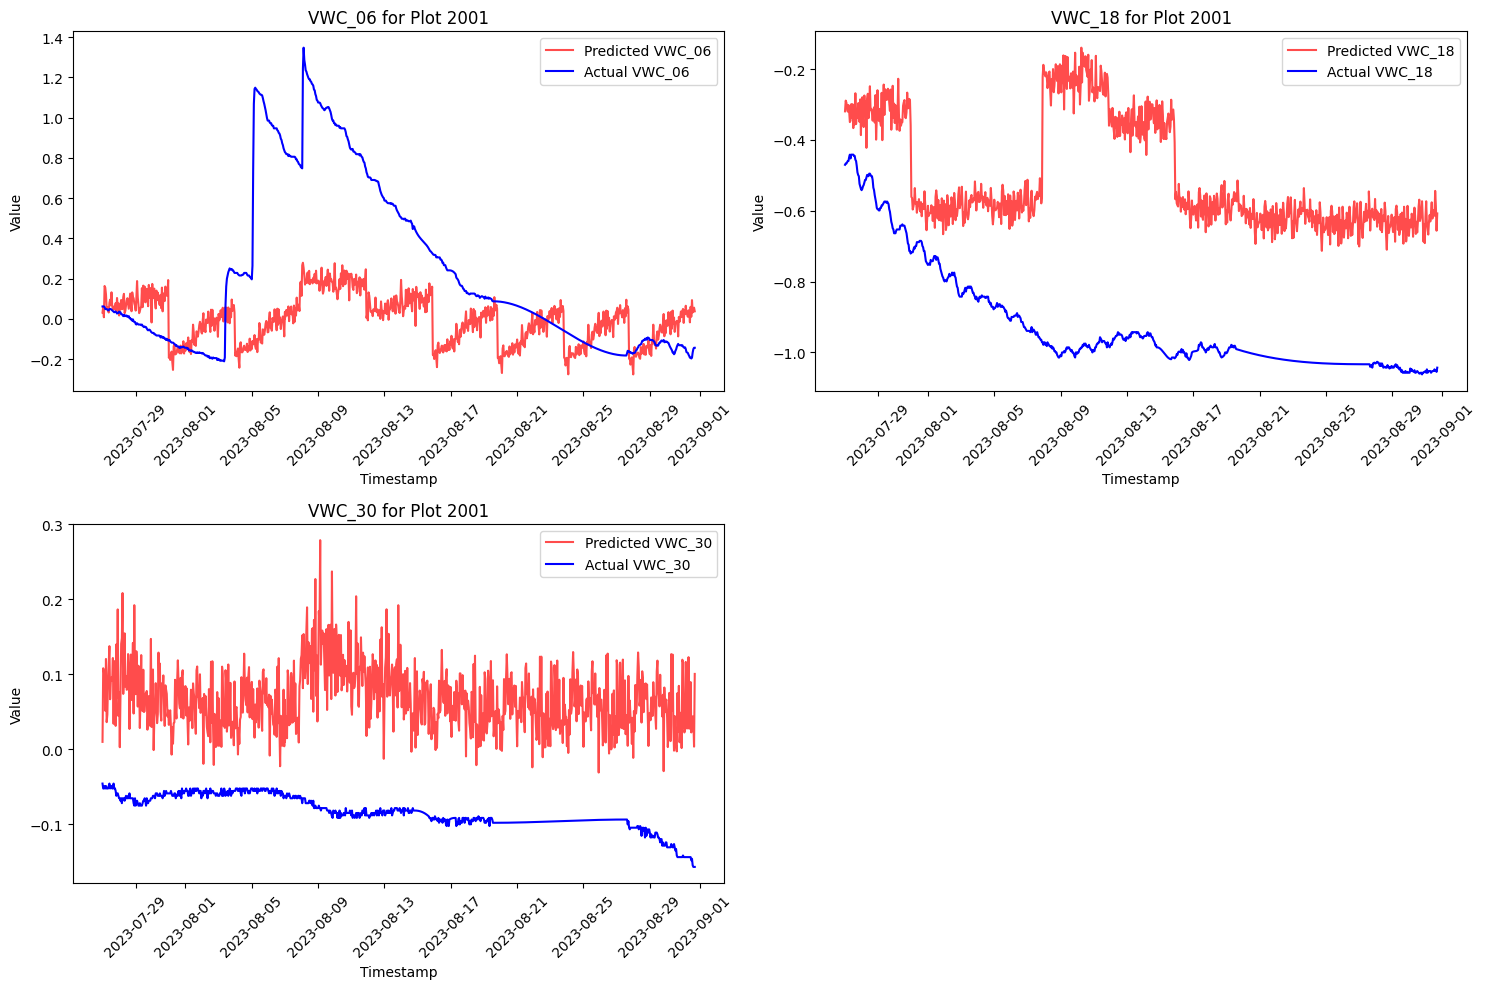

Shape of input DataFrame: (864, 3)
Shape of input DataFrame: (864, 3)
Values of predictions_df  and actuals_df after reverse transformation and scaling
                        VWC_06     VWC_18     VWC_30
TIMESTAMP                                           
2023-07-27 00:00:00  19.662930  16.853764  12.875266
2023-07-27 01:00:00  19.895477  17.065826  13.626019
2023-07-27 02:00:00  19.481756  17.025806  13.588251
                     VWC_06  VWC_18  VWC_30
TIMESTAMP                                  
2023-07-27 00:00:00    19.9  15.800   12.45
2023-07-27 01:00:00    19.9  15.825   12.40
2023-07-27 02:00:00    19.9  15.825   12.40
Plotting predictions and actuals after reverse transformation and scaling


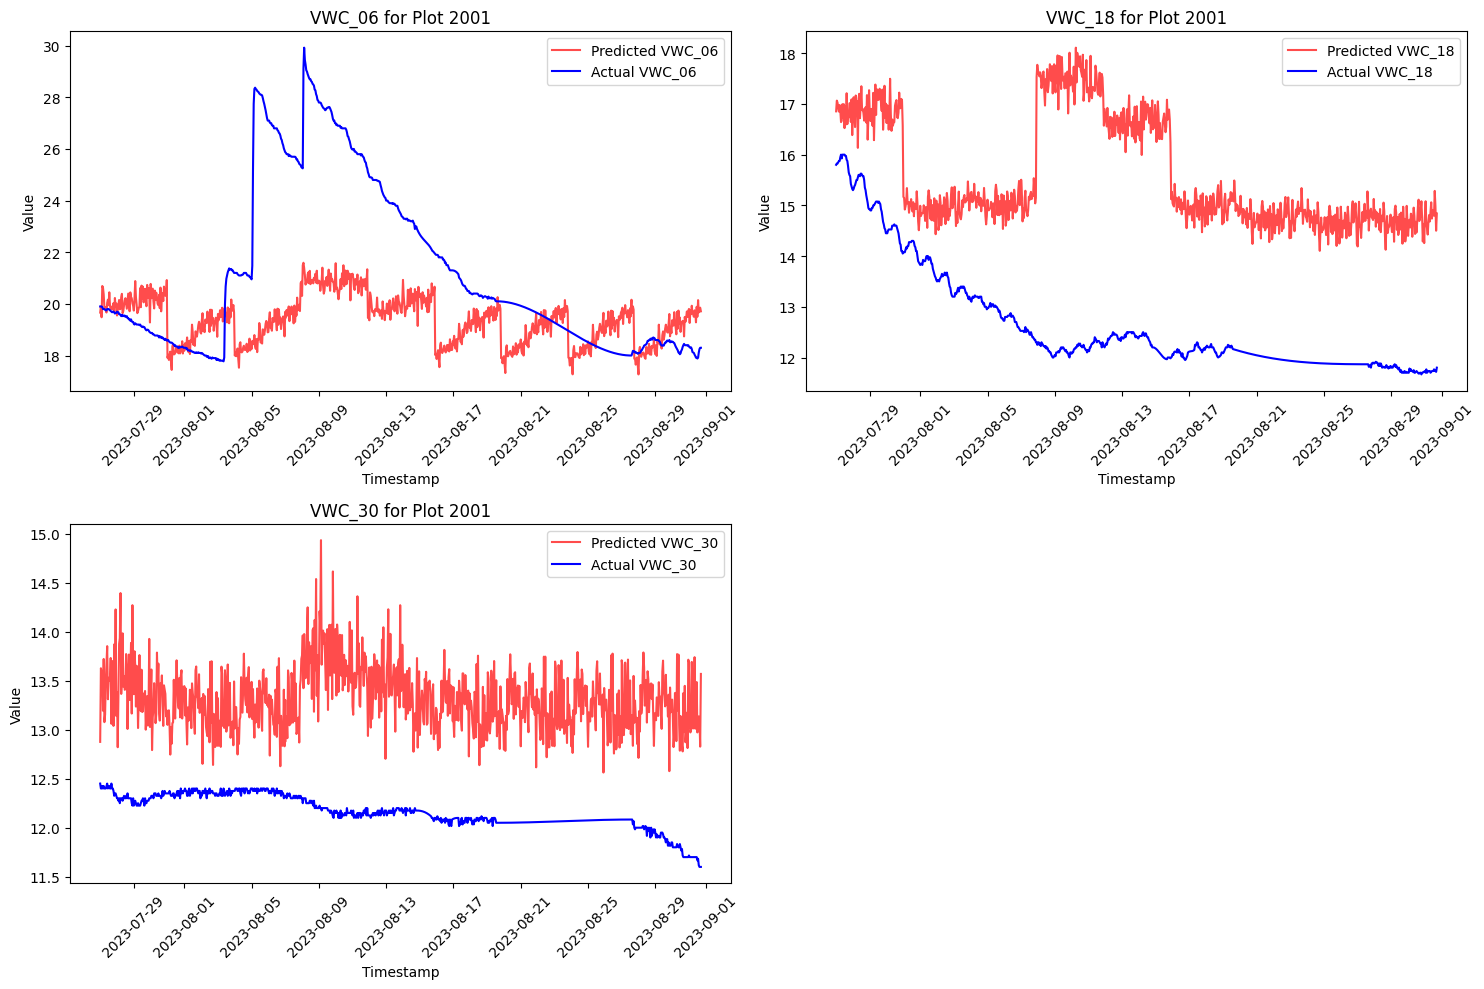

Processing plot number 2013
Mean of the transformed DataFrame: Ta_2m_Avg                 0.522445
RH_2m_Avg                 0.597641
Solar_2m_Avg              0.290297
WndAveSpd_3m              0.297052
Dp_2m_Avg                 0.564552
TaMax_2m                  0.522855
TaMin_2m                  0.521227
RHMax_2m                  0.602318
RHMin_2m                  0.593422
HeatIndex_2m_Avg          0.556502
canopy_temp               0.523788
VWC_06                   -0.205438
VWC_18                   -0.139159
VWC_30                    1.283395
daily_et                  0.293383
CWSI                      0.474152
SWSI                      0.504927
precip_irrig              0.007167
day_sin                   0.617893
day_cos                   0.305206
hour_sin                  0.494696
hour_cos                  0.501421
dow_sin                   0.493552
dow_cos                   0.468678
VWC_06_deriv              0.050788
VWC_18_deriv              0.080262
VWC_30_deriv              0

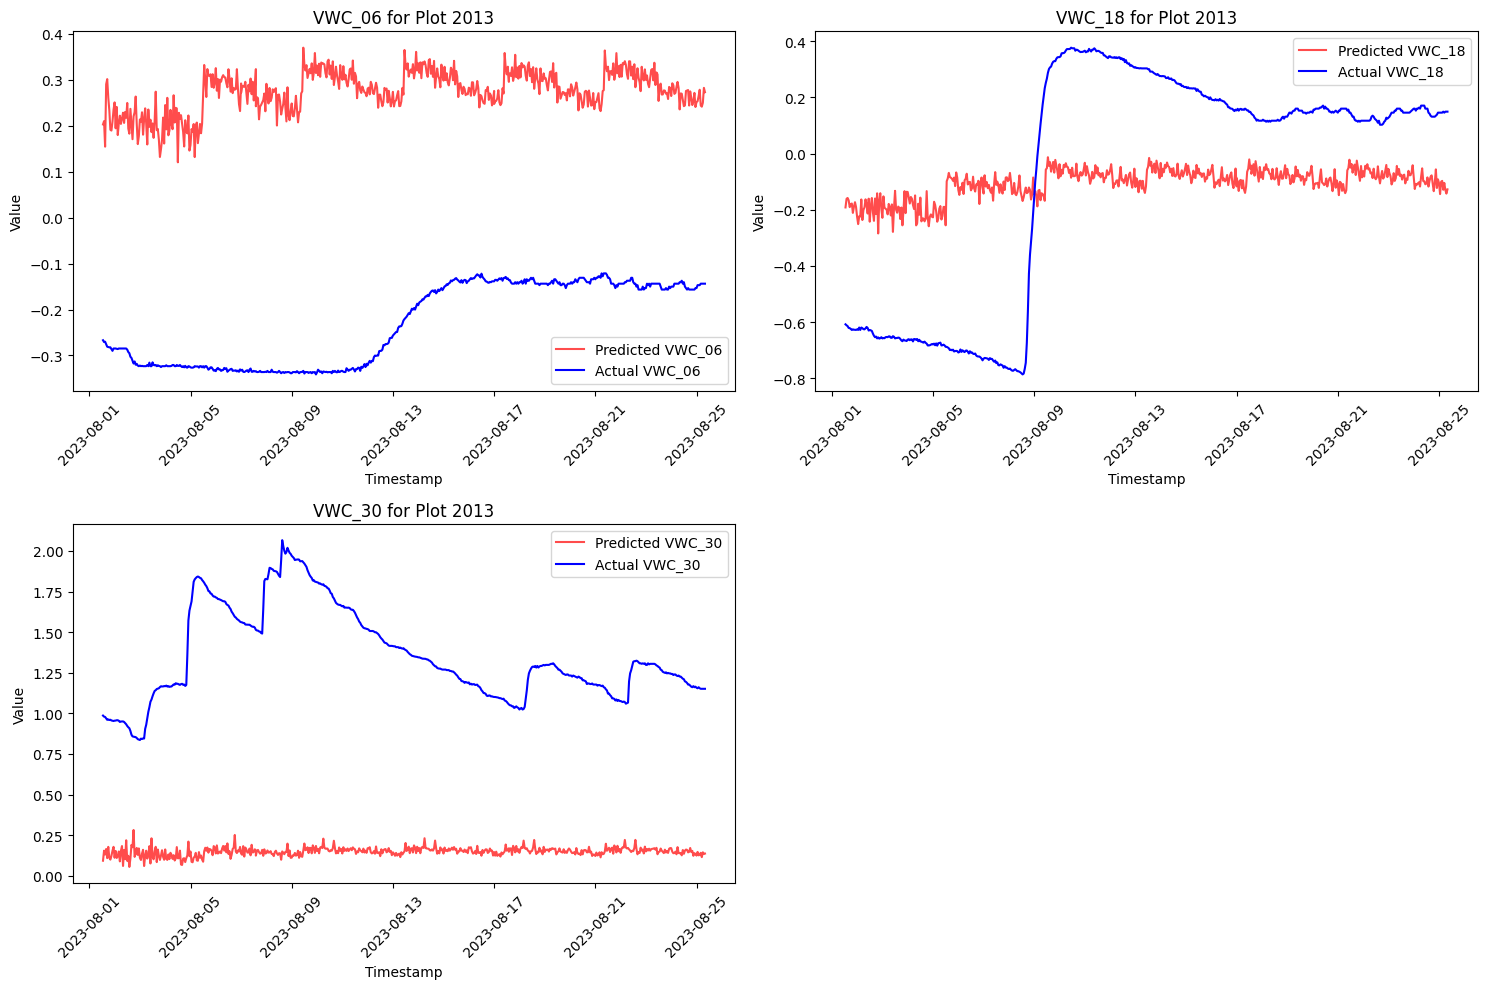

Shape of input DataFrame: (576, 3)
Shape of input DataFrame: (576, 3)
Values of predictions_df  and actuals_df after reverse transformation and scaling
                        VWC_06     VWC_18     VWC_30
TIMESTAMP                                           
2023-08-01 13:00:00  21.003094  17.744654  13.509573
2023-08-01 14:00:00  21.058712  17.958811  13.983818
2023-08-01 15:00:00  20.625679  17.980190  13.801741
                     VWC_06  VWC_18  VWC_30
TIMESTAMP                                  
2023-08-01 13:00:00  17.340  14.840  20.340
2023-08-01 14:00:00  17.310  14.815  20.290
2023-08-01 15:00:00  17.315  14.795  20.275
Plotting predictions and actuals after reverse transformation and scaling


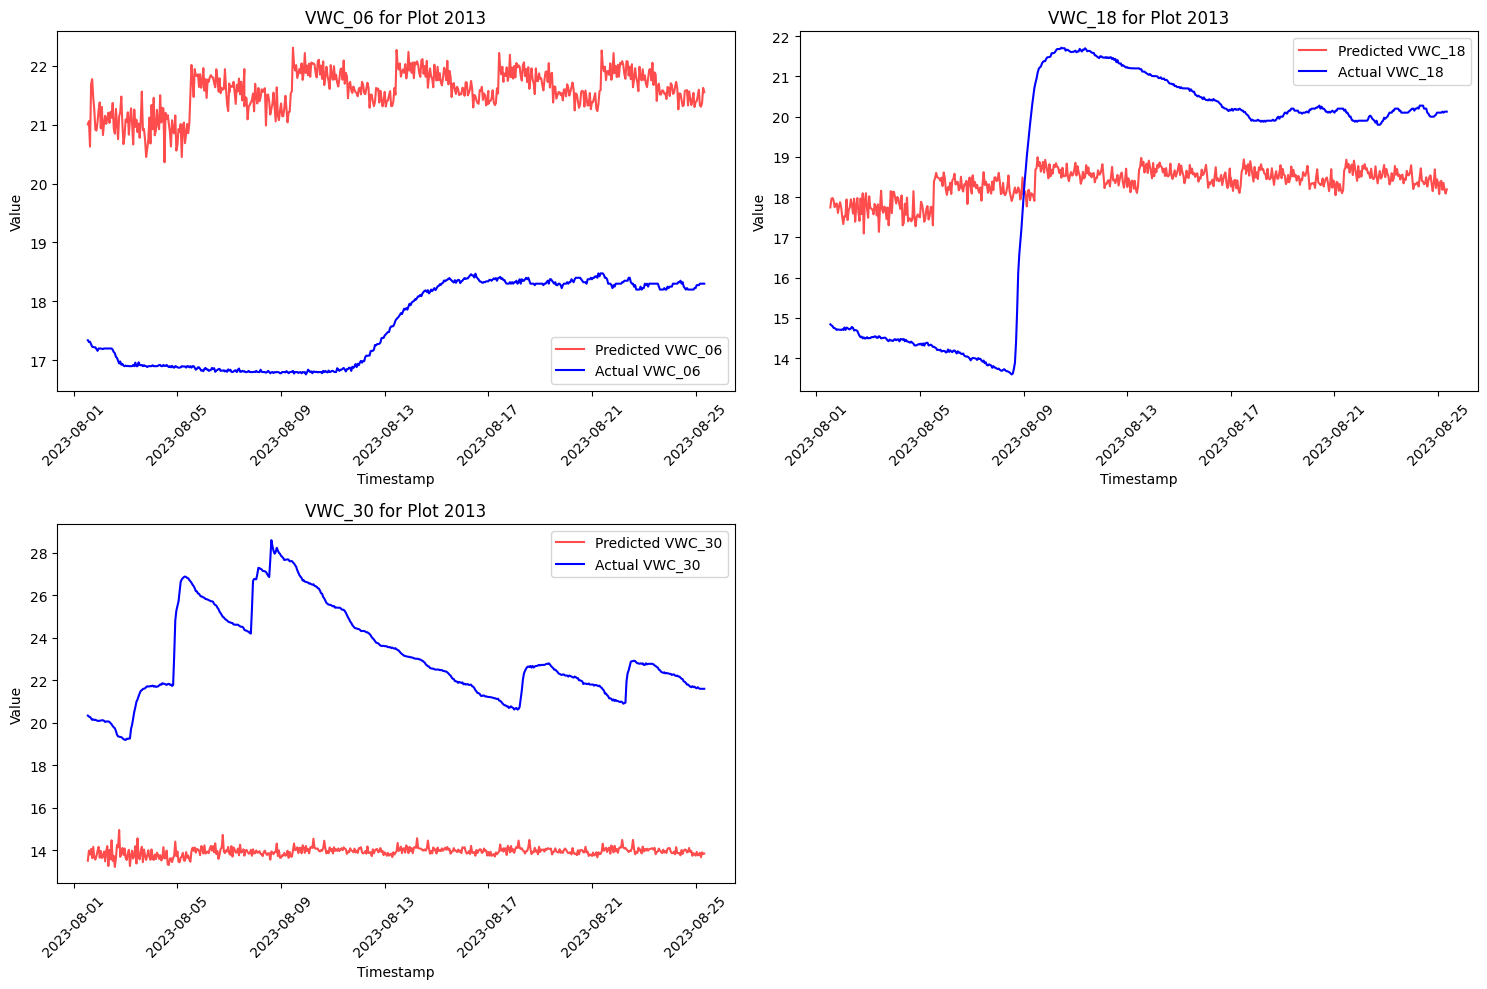

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

def plot_predictions(predictions_df, actuals_df, target_columns, plot_number):
    num_plots = len(target_columns)
    num_rows = int(np.ceil(num_plots / 2))  # You can adjust the number of columns per row if you like
    plt.figure(figsize=(15, 5 * num_rows))  # Adjust the figure size as needed
    for i, column in enumerate(target_columns):
        plt.subplot(num_rows, 2, i + 1)  # Adjust the number of columns per row if you like
        plt.plot(predictions_df.index, predictions_df[column], label=f'Predicted {column}', color='red', alpha=0.7)
        plt.plot(actuals_df.index, actuals_df[column], label=f'Actual {column}', color='blue')
        plt.legend()
        plt.title(f'{column} for Plot {plot_number}')
        plt.xlabel('Timestamp')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def predict_with_sliding_window(model, df, current_transformation_metadata, target_columns, input_window, forecast_horizon, plot_number):
    # Create input& target data, input data is all columns except target columns
    target_data = df[target_columns].values
    input_data = df.values
    predictions = []
    actuals = []
    timestamps = []
    
    # first iteration flag
    first_iter = True

    # Adjust stride based on prediction: 1 for continuous sliding
    stride = forecast_horizon
    for start in range(0, len(df) - input_window - forecast_horizon + 1, stride):
        end = start + input_window
        if end + forecast_horizon > len(input_data):
            break
        sequence = input_data[start:end]
        sequence = sequence.reshape((1, input_window, len(input_data[0])))

        

        pred = model.predict(sequence)

        
        if first_iter:
            print(f"Sequence shape: {sequence.shape}")
            # To print the top 3 lines, slice the second dimension (sequence length)
            print("Sequence (top 3 lines):")
            print(sequence[0, :3, :])  # Access the first element of the first dimension, then slice
            print(f"Predicted shape: {pred.shape}")
            # Similarly, for the predictions, slice the second dimension
            print("Predicted (top 3 lines):")
            print(pred[0, :3, :])  # Access the first element of the first dimension, then slice
        
            first_iter = False


        pred = pred.reshape(-1, pred.shape[-1])
        predictions.append(pred)
        actuals.append(target_data[end:end + forecast_horizon])
        timestamp_series = pd.Series(df.index[end:end + forecast_horizon], index=df.index[end:end + forecast_horizon])
        timestamps.append(timestamp_series)

    predictions = np.concatenate(predictions)
    actuals = np.concatenate(actuals)
    timestamps = pd.concat(timestamps)

    # Create the DataFrame with the reshaped predictions and the correct timestamps
    predictions_df = pd.DataFrame(predictions, columns=target_columns, index=timestamps)
    actuals_df = pd.DataFrame(actuals, columns=target_columns, index=timestamps)

    # Apply reverse transformation and scaling to both predictions and actuals

    # Plot the predictions and actuals before reverse transformation and scaling
    print("Plotting predictions and actuals before reverse transformation and scaling")
    print("Values of predictions_df  and actuals_df before reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))

    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    # Apply reverse transformation and scaling to both predictions and actuals
    predictions_df = reverse_transform_and_scale_data(predictions_df, current_transformation_metadata, target_columns)
    actuals_df = reverse_transform_and_scale_data(actuals_df, current_transformation_metadata, target_columns)

    # Example usage
    print("Values of predictions_df  and actuals_df after reverse transformation and scaling")
    print(predictions_df.head(3))
    print(actuals_df.head(3))
    print("Plotting predictions and actuals after reverse transformation and scaling")
    plot_predictions(predictions_df, actuals_df, target_columns, plot_number)

    return predictions_df, actuals_df, timestamps

# Array of plot numbers
plot_numbers = [2001, 2013]

# initialize predictions_df and actuals_df and timestamps as empty dataframes
predictions_df = pd.DataFrame()
actuals_df = pd.DataFrame()
timestamps = pd.Series()

# initialize scalers from transformation_metadata
scalers = transformation_metadata['scalers']
keep_original_cols = transformation_metadata['keep_original_cols'] 

# Loop through plot numbers
for plot_number in plot_numbers:
    print(f"Processing plot number {plot_number}")
    
    model = tf.keras.models.load_model(checkpoint_path)
    

    df_plot = process_data_for_plot(plot_number)
    
    #drop VWC_40 column if it exists
    if 'VWC_42' in df_plot.columns:
        df_plot = df_plot.drop(columns=['VWC_42'])

    df_plot, current_transform_metadata = transform_and_scale_data(df_plot, target_columns, scalers, keep_original_cols)
    
    # print the mean of the transformed dataframe
    print(f"Mean of the transformed DataFrame: {df_plot.mean()}")

    
    predictions_df, actuals_df, timestamps = predict_with_sliding_window(model, df_plot, current_transformation_metadata=current_transform_metadata, 
                                                                         target_columns=target_columns, input_window=24*7, forecast_horizon=96, plot_number=plot_number)
